In [1]:
from Function.Function import *
from os.path import abspath , join
current_folder =abspath('');current_folder



Using TensorFlow backend.
C:\Users\Zackt\Anaconda3\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Zackt\Anaconda3\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Zackt\Anaconda3\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Zackt\Anaconda3\lib\site-packages\tensorboard\comp

'D:\\jupyter\\Project_796'

# Preprocessing data

In [4]:
period = 400 #  days for train
period_valid = 400 # days for test
stock ,spy =get_data(period,period_valid)

# Construct model

In [35]:
dimension_of_input  = len(stock['calibrate']['lp'].columns) # number of stock
autoencoder = inital_model(dimension_of_input)
# train model
# we use net difference to train model
data = stock['calibrate']['net']
#nomalization standardlization
autoencoder.fit(data, data, shuffle=False, epochs=500, batch_size = 10 , verbose = 0)

In [36]:
autoencoder.save(join(current_folder,'Models/com_autoencoder_{}.h5'.format(period)))

# Predict and Pick the stocks

In [5]:
path = join(current_folder,'Models/best/com_autoencoder_{}.h5'.format(period))
autoencoder = load_model(path)
data = stock['calibrate']['net']
predict = autoencoder.predict(data) 
# use different error measure to decide which stocks are market followers which are not

# we need to figure out what is the best error measure,?

# sum absolute relative error
communal_information = np.sum(np.absolute((stock['calibrate']['net'] - predict)/stock['calibrate']['net']),axis = 0) 
# ranking
ranking = np.array(communal_information).argsort()
ranks = pd.DataFrame({'communal' : communal_information[ranking] ,'index' : data.columns[ranking] })
ranks

,communal,index
BKNG,268.252556,BKNG
GOOGL,468.200041,GOOGL
CHD,481.483446,CHD
KR,491.796197,KR
JNJ,545.160914,JNJ
...,...,...
PEG,inf,PEG
MSCI,inf,MSCI
AFL,inf,AFL
WLTW,inf,WLTW


# Let see what the best one looks like

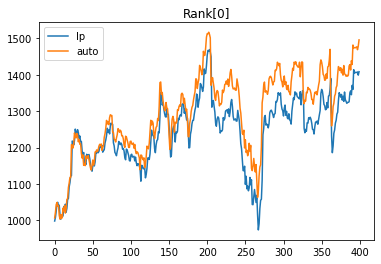

In [6]:
index = ranking[0]
stock_autoencoder = copy.deepcopy(predict[:, index]);stock_autoencoder
stock_autoencoder = stock_autoencoder.cumsum()
stock_autoencoder += (stock['calibrate']['lp'].iloc[0, index])
## plot for comparison
plt.plot(np.array(stock['calibrate']['lp'].iloc[:, index]),label = 'lp')
plt.plot(stock_autoencoder,label = 'auto')
plt.title('Rank[0]')
plt.legend()


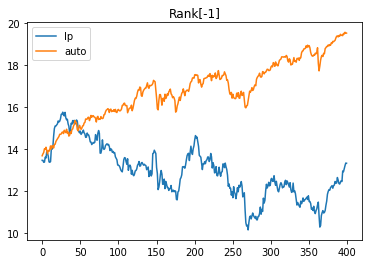

In [7]:
index = ranking[-1]
stock_autoencoder = copy.deepcopy(predict[:, index]);stock_autoencoder
stock_autoencoder = stock_autoencoder.cumsum()
stock_autoencoder += (stock['calibrate']['lp'].iloc[0, index])
## plot for comparison
plt.plot(np.array(stock['calibrate']['lp'].iloc[:, index]),label = 'lp')
plt.plot(stock_autoencoder,label = 'auto')
plt.title('Rank[-1]')
plt.legend()


# Calibriation for reproducing the market after dimension reduction

In [9]:
spy_predict = defaultdict(defaultdict)
total_2_norm_diff = defaultdict(defaultdict)
dl_scaler = defaultdict(StandardScaler)
non = np.array([15, 35, 55]) # numbrt of non_communal ??
initial = 50 # number of market follower  ??

# test different number of non_communal
for non_communal in non:  
    s = initial + non_communal # dimension of inputs, number of stocks
    stock_index = np.concatenate((ranking[0:initial], ranking[-non_communal:])) # set the index of portoflio
    
    
    # inital model
    autoencoder = inital_model_portfolio(s)
    
    x = stock['calibrate']['percentage'].iloc[:, stock_index]
    y = spy['calibrate']['percentage']
    # normalize the data ( clean)
    dl_scaler[s] = StandardScaler()     
    dl_scaler[s].fit(x)
    x = dl_scaler[s].transform(x)  
    
    autoencoder.fit(x, y, shuffle=False, epochs=500, batch_size = 10 , verbose = 0)    # fit the model
    autoencoder.save(join(current_folder,'Models/trained_autoencoder{}.h5'.format(s)))
    
    #calculate the error
    relative_percentage = copy.deepcopy(autoencoder.predict(x))/100 + 1
    
    
    spy_predict['calibrate'][s] = spy['calibrate']['lp'].iloc[0,0] * np.concatenate([[1],(relative_percentage.cumprod())])          
    total_2_norm_diff['calibrate'][s] = np.linalg.norm(np.array(spy_predict['calibrate'][s]) - np.array(spy['calibrate']['lp']))

Text(0.5, 1.0, 'In the sample')

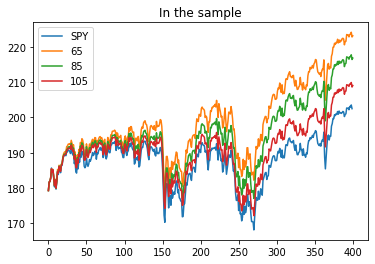

In [10]:
# plot results 
plt.plot(np.array(spy['calibrate']['lp'] ), label = 'SPY')

for s in (initial + non):
   
    plt.plot(np.array(spy_predict['calibrate'][s] ), label = '{}'.format(s))
plt.legend()
plt.title('In the sample')

In [11]:
print(total_2_norm_diff['calibrate'])

defaultdict(None, {65: 6652.330742640031, 85: 5415.54179361355, 105: 4339.016803045551})


# validating out of sample

In [ ]:
for non_communal in non:  
    s = initial + non_communal
    stock_index = np.concatenate((ranking[0:initial], ranking[-non_communal:])) # portfolio index
    
    # load  trained models
    deep_learner = load_model(join(current_folder,'Models/trained_autoencoder{}.h5'.format(s)))
    
    
    x = stock['validate']['percentage'].iloc[:, stock_index]
    dl_scaler[s].fit(x)
    x = dl_scaler[s].transform(x)  
    
    # calculate the error
    relative_percentage = copy.deepcopy(deep_learner.predict(x))

    relative_percentage = (relative_percentage /100) + 1
    
    spy_predict['validate'][s] = spy['validate']['lp'].iloc[0,0] * np.concatenate([[1],(relative_percentage.cumprod())])       
    total_2_norm_diff['validate'][s] = np.linalg.norm((np.array(spy_predict['validate'][s]) - np.array(spy['validate']['lp'])))

# plot result
plt.plot(np.array(spy['validate']['lp'] ), label = 'SPY')

for s in (initial + non): 
    plt.plot(np.array(spy_predict['validate'][s] ), label = '{}'.format(s))
plt.legend()
plt.title('Out of the sample')

# Beat the market

In [5]:
spy_predict = defaultdict(defaultdict)
total_2_norm_diff = defaultdict(defaultdict)
dl_scaler = defaultdict(StandardScaler)
non = np.array([15, 35, 55]) # numbrt of non_communal ??
initial = 50 # number of market follower  ??
y = copy.deepcopy (spy['calibrate']['percentage'])
# we change the the path of y and ask
y[y < -1.5] = 1


In [58]:
# test different number of non_communal
for non_communal in non:  
    encoding_dim = 128 
    s = initial + non_communal # dimension of inputs, number of stocks
    stock_index = np.concatenate((ranking[0:initial], ranking[-non_communal:])) # set the index of portoflio
    
    
    #  initial model
    autoencoder = inital_model_portfolio(s)
        
    x = stock['calibrate']['percentage'].iloc[:, stock_index]

    # normalize the data ( clean)
    dl_scaler[s] = StandardScaler()     
    dl_scaler[s].fit(x)
    x = dl_scaler[s].transform(x)  
    
    autoencoder.fit(x, y, shuffle=False, epochs=500, batch_size = 10 , verbose = 0)    # fit the model
    autoencoder.save(join(current_folder,'Models/beat_market_autoencoder{}.h5'.format(s)))
    
    #calculate the error
    relative_percentage = copy.deepcopy(autoencoder.predict(x))
    
    relative_percentage = (relative_percentage/100 ) + 1
    
    spy_predict['calibrate'][s] = spy['calibrate']['lp'].iloc[0,0] * np.concatenate([[1],relative_percentage.cumprod()])  
    total_2_norm_diff['calibrate'][s] = np.linalg.norm(np.array(spy_predict['calibrate'][s]) - np.array(spy['calibrate']['lp']))

Text(0.5, 1.0, 'SPY vs Adjusted SPY vs Decoposition')

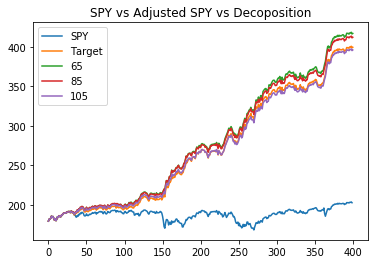

In [67]:
ypath = spy['calibrate']['lp'].iloc[0,0] * np.concatenate([[1],np.array((y/100)+1).cumprod()])  
# plot result
plt.plot(np.array(spy['calibrate']['lp'] ), label = 'SPY')
plt.plot(ypath,label= 'Target')
for s in (initial + non): 
    plt.plot(np.array(spy_predict['calibrate'][s] ), label = '{}'.format(s))
plt.legend()
plt.title('SPY vs Adjusted SPY vs Decoposition')

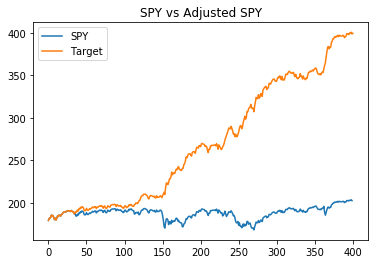

In [66]:
plt.plot(np.array(spy['calibrate']['lp'] ), label = 'SPY')
plt.plot(ypath,label= 'Target')
plt.title('SPY vs Adjusted SPY')
plt.legend()

# The last ( real world) 
# Validating

Text(0.5, 1.0, 'SPY vs Auto portfolio')

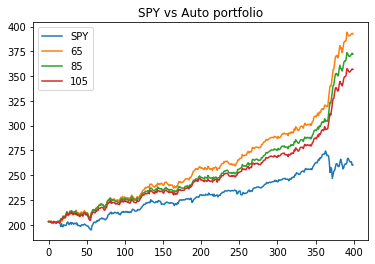

In [15]:
for non_communal in non:  
    s = initial + non_communal
    stock_index = np.concatenate((ranking[0:initial], ranking[-non_communal:])) # portfolio index
    
    # load  trained models
    deep_learner = load_model(join(current_folder,'Models/beat_market_autoencoder{}.h5'.format(s)))
    
    
    x = stock['validate']['percentage'].iloc[:, stock_index]
    dl_scaler[s].fit(x)
    x = dl_scaler[s].transform(x)  
    
    # calculate the error
    relative_percentage = copy.deepcopy(deep_learner.predict(x))

    relative_percentage = (relative_percentage /100) + 1
    
    spy_predict['validate'][s] = spy['validate']['lp'].iloc[0,0] * (relative_percentage.cumprod())          
    total_2_norm_diff['validate'][s] = np.linalg.norm((np.array(spy_predict['validate'][s]) - np.array(spy['validate']['lp'])))

# plot result
plt.plot(np.array(spy['validate']['lp'] ), label = 'SPY')

for s in (initial + non): 
    plt.plot(np.array(spy_predict['validate'][s] ), label = '{}'.format(s))
plt.legend()
plt.title('SPY vs Auto portfolio')

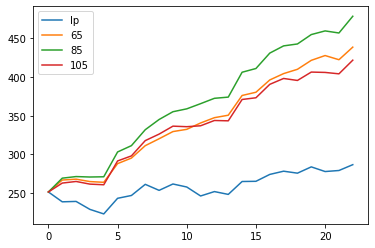

In [49]:
stock ,spy =get_data(1300,1500)
for non_communal in non:  
    s = initial + non_communal
    stock_index = np.concatenate((ranking[0:initial], ranking[-non_communal:])) # portfolio index
    
    # load  trained models
    deep_learner = load_model(join(current_folder,'Models/beat_market_autoencoder{}.h5'.format(s)))
    
    
    x = stock['validate']['percentage'].iloc[:, stock_index]
    x = dl_scaler[s].transform(x)  
    
    # calculate the error
    relative_percentage = copy.deepcopy(deep_learner.predict(x))

    relative_percentage = np.concatenate([[1],np.ndarray.flatten(np.array((relative_percentage /100) + 1))])
    
    spy_predict['validate'][s] = spy['validate']['lp'].iloc[0,0] * (relative_percentage.cumprod())          
    total_2_norm_diff['validate'][s] = np.linalg.norm((np.array(spy_predict['validate'][s]) - np.array(spy['validate']['lp'])))

# plot result
plt.plot(np.array(spy['validate']['lp'] ), label = 'lp')

for s in (initial + non): 
    plt.plot(np.array(spy_predict['validate'][s] ), label = '{}'.format(s))
plt.legend()

In [48]:
np.ndarray.flatten(np.array((relative_percentage /100) + 1))

array([1.0614715 , 1.0042161 , 0.98839676, 0.99637735, 1.0915264 ,
       1.0250006 , 1.0543698 , 1.0286868 , 1.0289965 , 1.0088571 ,
       1.024705  , 1.0201117 , 1.0091662 , 1.072816  , 1.0111225 ,
       1.0417672 , 1.0207696 , 1.0137395 , 1.028276  , 1.0146922 ,
       0.9873944 , 1.038545  ], dtype=float32)

In [ ]:
stock ,spy =get_data(500,200)
for non_communal in non:  
    s = initial + non_communal
    stock_index = np.concatenate((ranking[0:initial], ranking[-non_communal:])) # portfolio index
    
    # load  trained models
    deep_learner = load_model(join(current_folder,'Models/beat_market_autoencoder{}.h5'.format(s)))
    
    
    x = stock['validate']['percentage'].iloc[:, stock_index]
    x = dl_scaler[s].transform(x)  
    
    # calculate the error
    relative_percentage = copy.deepcopy(deep_learner.predict(x))

    relative_percentage = (relative_percentage /100) + 1
    
    spy_predict['validate'][s] = spy['validate']['lp'].iloc[0,0] * (relative_percentage.cumprod())          
    total_2_norm_diff['validate'][s] = np.linalg.norm((np.array(spy_predict['validate'][s]) - np.array(spy['validate']['lp'])))

# plot result
plt.plot(np.array(spy['validate']['lp'] ), label = 'lp')

for s in (initial + non): 
    plt.plot(np.array(spy_predict['validate'][s] ), label = '{}'.format(s))
plt.legend()